# Summarize the results of our multiple rounds of piloting
For each pilot, this notebook will include:
    1) the experimental manipulations introduced
    2) the overall results (mean performance on each task)
    3) the key analysis (tilt x race) on each pilot

First, import libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime 
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
import matplotlib.image as mpimg
import re
save_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/main/'

### Defining helper functions

In [3]:
def rand_jitter(arr, stdev):
    return arr + np.random.randn(len(arr)) * stdev

In [4]:
def compute_dp(n_hit, n_old, n_fa, n_new):
    hitrate = n_hit/n_old
    farate = n_fa/n_new
    
    if hitrate == 1 or farate == 0:
        # Hautus's correction
        hitrate = (n_hit+0.5)/(n_old+1)
        farate = (n_fa + 0.5)/(n_old+1)
    
    return norm.ppf(hitrate) - norm.ppf(farate)

In [5]:
def tilt_to_number(tilt):
    num = int(re.search(r'\d+', tilt).group())
    if tilt.endswith('L'):
        num = -num
    return num
    
def number_to_tilt(num):
    if num < 0:
        s = str(-num) + 'L'
    elif num > 0:
        s = str(num) + 'R'
    else: 
        s = '00C'
    return s
        
def get_tilt_change(o_tilt, n_tilt):
    difference = tilt_to_number(o_tilt) - tilt_to_number(n_tilt)
    change = number_to_tilt(difference)

    return {
        'change': change,
        'difference': difference
    }

In [6]:
# calculate a whole bunch of useful measures for each subject
def get_stats(data):
    df_stat = pd.DataFrame(columns = ['subject_id',
                                  'enc_acc', 'enc_acc_white', 'enc_acc_black', 'enc_acc_delta',
                                  'enc_rt', 'enc_rt_white', 'enc_rt_black', 'enc_rt_delta',
                                  'fil_acc', 'fil_rt', 
                                  'ret_acc', 'ret_acc_white', 'ret_acc_black', 'ret_acc_delta',
                                  'ret_rt', 'ret_rt_white', 'ret_rt_black', 'ret_rt_delta',
                                  'ret_d', 'ret_d_white', 'ret_d_black', 'ret_d_delta',
                                  # breaking down by tilt
                                    'ret_acc_0', 'ret_acc_50', 'ret_acc_p50', 'ret_acc_n50', 
                                  'ret_acc_w_0', 'ret_acc_w_50', 'ret_acc_b_0', 'ret_acc_b_50',
                                  
                                 ])
    
    if 'afc' in data.iteration.iloc[0]: 
        race_help = 'old_race'
        afc = True
    else: 
        race_help = 'race'
        afc = False
    
    for i_sub in data.subject_id.unique():

        enc = data[(data.subject_id == i_sub) & (data.trial_type == 'encoding')]

        curr = [i_sub]

        curr.append(enc.mean()['correct'])
        curr.append(enc.groupby('oddity_race').mean()['correct']['white'])
        curr.append(enc.groupby('oddity_race').mean()['correct']['black'])
        curr.append( enc.groupby('oddity_race').mean()['correct']['white'] - 
                     enc.groupby('oddity_race').mean()['correct']['black'])

        curr.append(enc.mean()['rt'])
        curr.append(enc.groupby('oddity_race').mean()['rt']['white'])
        curr.append(enc.groupby('oddity_race').mean()['rt']['black'])
        curr.append( enc.groupby('oddity_race').mean()['rt']['white'] - 
                                 enc.groupby('oddity_race').mean()['rt']['black'])

        fil = data[(data.subject_id == i_sub) & (data.trial_type == 'filler')]
        curr.append(fil.mean()['correct'])
        curr.append(fil.mean()['rt'])

        ret = data[(data.subject_id == i_sub) & ((data.trial_type == 'retrieval') | (data.trial_type == 'retrieval_practice'))]

        curr.append(ret.mean()['correct'])
        curr.append(ret.groupby(race_help).mean()['correct']['white'])
        curr.append(ret.groupby(race_help).mean()['correct']['black'])
        curr.append(ret.groupby(race_help).mean()['correct']['white'] - 
                                 ret.groupby(race_help).mean()['correct']['black'])

        curr.append(ret.mean()['rt'])
        curr.append(ret.groupby(race_help).mean()['rt']['white'])
        curr.append(ret.groupby(race_help).mean()['rt']['black'])
        curr.append( ret.groupby(race_help).mean()['rt']['white'] - 
                                 ret.groupby(race_help).mean()['rt']['black'])

        # now, break down by tilt condition
        
        if (afc):
            curr.extend([0,0,0,0]) # for the d' values
            
            hit_w_0 = len(ret[(~ret.tilted) & (ret.correct == 1) & (ret[race_help] == 'white')])
            hit_w_p50 = len(ret[(ret.tilt_difference == 50) & (ret.correct == 1) & (ret[race_help] == 'white')])
            hit_w_n50 = len(ret[(ret.tilt_difference == -50) & (ret.correct == 1) & (ret[race_help] == 'white')])
            old_w_0 = len(ret[(~ret.tilted) & (ret[race_help] == 'white')])
            old_w_p50 = len(ret[(ret.tilt_difference == 50) & (ret[race_help] == 'white')])
            old_w_n50 = len(ret[(ret.tilt_difference == -50) & (ret[race_help] == 'white')])

            hit_b_0 = len(ret[(~ret.tilted) & (ret.correct == 1) & (ret[race_help] == 'black')])
            hit_b_p50 = len(ret[(ret.tilt_difference == 50) & (ret.correct == 1) & (ret[race_help] == 'black')])
            hit_b_n50 = len(ret[(ret.tilt_difference == -50) & (ret.correct == 1) & (ret[race_help] == 'black')])
            old_b_0 = len(ret[(~ret.tilted) & (ret[race_help] == 'black')])
            old_b_p50 = len(ret[(ret.tilt_difference == 50) & (ret[race_help] == 'black')])
            old_b_n50 = len(ret[(ret.tilt_difference == -50) & (ret[race_help] == 'black')])
            
        else: 
            d = compute_dp(
                len(ret[(ret.retrieval_condition == 'old') & (ret.correct == 1)]), # n_hit
                len(ret[ret.retrieval_condition == 'old']), # n_old
                len(ret[(ret.retrieval_condition == 'new') & (ret.correct == 0)]), # n_fa
                len(ret[ret.retrieval_condition == 'new']), # n_new
                )

            d_w = compute_dp(
                len(ret[(ret.retrieval_condition == 'old') & (ret.race == 'white') & (ret.correct == 1)]),
                len(ret[(ret.retrieval_condition == 'old') & (ret.race == 'white')]),
                len(ret[(ret.retrieval_condition == 'new') & (ret.race == 'white') & (ret.correct == 0)]),
                len(ret[(ret.retrieval_condition == 'new') & (ret.race == 'white')])
                )
            d_b = compute_dp(
                len(ret[(ret.retrieval_condition == 'old') & (ret.race == 'black') & (ret.correct == 1)]),
                len(ret[(ret.retrieval_condition == 'old') & (ret.race == 'black')]),
                len(ret[(ret.retrieval_condition == 'new') & (ret.race == 'black') & (ret.correct == 0)]),
                len(ret[(ret.retrieval_condition == 'new') & (ret.race == 'black')])
                )

            curr.extend([d, d_w, d_b, d_w-d_b]) # these won't work for the afc condition

            hit_w_0 = len(ret[(ret.retrieval_condition == 'old') & (~ret.tilted) & (ret.correct == 1) & (ret.race == 'white')])
            hit_w_p50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == 50) & (ret.correct == 1) & (ret.race == 'white')])
            hit_w_n50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == -50) & (ret.correct == 1) & (ret.race == 'white')])
            hit_w_50 = hit_w_p50 + hit_w_n50
            old_w_0 = len(ret[(ret.retrieval_condition == 'old') & (~ret.tilted) & (ret.race == 'white')])
            old_w_p50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == 50) & (ret.race == 'white')])
            old_w_n50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == -50) & (ret.race == 'white')])

            hit_b_0 = len(ret[(ret.retrieval_condition == 'old') & (~ret.tilted) & (ret.correct == 1) & (ret.race == 'black')])
            hit_b_p50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == 50) & (ret.correct == 1) & (ret.race == 'black')])
            hit_b_n50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == -50) & (ret.correct == 1) & (ret.race == 'black')])
            hit_b_50 = hit_w_p50 + hit_w_n50
            old_b_0 = len(ret[(ret.retrieval_condition == 'old') & (~ret.tilted) & (ret.race == 'black')])
            old_b_p50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == 50) & (ret.race == 'black')])
            old_b_n50 = len(ret[(ret.retrieval_condition == 'old') & (ret.tilt_difference == -50) & (ret.race == 'black')])

        hit_w_50 = hit_w_p50 + hit_w_n50
        hit_b_50 = hit_w_p50 + hit_w_n50
        old_w_50 = old_w_p50 + old_w_n50
        old_b_50 = old_b_p50 + old_b_n50
        
        hit_0 = hit_w_0 + hit_b_0
        old_0 = old_w_0 + old_b_0 
        hit_50 = hit_w_50 + hit_b_50
        old_50 = old_w_50 + old_b_50
        hit_p50 = hit_w_p50 + hit_b_p50
        old_p50 = old_w_p50 + old_b_p50
        hit_n50 = hit_w_n50 + hit_b_n50
        old_n50 = old_w_n50 + old_b_n50


        curr.extend([
            hit_0 / old_0, # ret_acc_0
            hit_50 / old_50, # ret_acc_50

            hit_p50 / old_p50, # ret_acc_p50
            hit_n50 / old_n50, # ret_acc_n50

            hit_w_0 / old_w_0, # ret_acc_w_0
            hit_w_50 / old_w_50, # ret_acc_w_50
            hit_b_0 / old_b_0, # ret_acc_b_0
            hit_b_50 / old_b_50, # ret_acc_b_50


        ])

        df_stat.loc[len(df_stat)] = curr
               
    return df_stat

Plotting functions to be used throughout

In [7]:
# plot mean performance on each of the 3 tasks
def summary_plot(summary_data):
    lims = (40,100)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,7))
    fig.suptitle('Task performance')
    
    ax1.boxplot(summary_data.encoding_accuracy)
    ax1.set_xlabel('Encoding')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(lims)

    ax2.boxplot(summary_data.filler_accuracy)
    ax2.set_xlabel('Filler')
    ax2.set_ylim(lims)

    ax3.boxplot(summary_data.retrieval_accuracy)
    ax3.set_xlabel('Retrieval')
    ax3.set_ylim(lims)

    plt.show()

In [8]:
def encoding_plot(df_stat):
    # encoding rt vs. accuracy
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    lims = (0,100)
    fig.suptitle('Encoding RT vs. Encoding Accuracy')
    ax.scatter(df_stat.enc_rt, df_stat.enc_acc)
    ax.set_xlabel('Response time (ms)')
    ax.set_ylabel('Accuracy (%)')
    plt.show()
    
def encoding_filler_plot(df_stat):
    # encoding rt and accuracy vs. filler rt and accuracy
    sz = (8,8)

    fig, ax = plt.subplots(2, 2, figsize=sz)
    fig.suptitle('Encoding vs. Filler')
    
    ax[0][0].set_title('Encoding RT vs. Filler RT')
    ax[0][0].scatter(df_stat.enc_rt, df_stat.fil_rt)
    
    ax[0][1].set_title('Encoding RT vs. Filler Accuracy')
    ax[0][1].scatter(df_stat.enc_rt, df_stat.fil_acc)
    
    ax[1][0].set_title('Encoding Accuracy vs. Filler RT')
    ax[1][0].scatter(df_stat.enc_acc, df_stat.fil_rt)
    
    ax[1][1].set_title('Encoding Accuracy vs. Filler Accuracy')
    ax[1][1].scatter(df_stat.enc_acc, df_stat.fil_acc)
    
    plt.show()
    
def encoding_retrieval_plot(df_stat):
    # encoding rt and accuracy vs. retrieval rt and accuracy
    sz = (8,8)

    fig, ax = plt.subplots(2, 2, figsize=sz)
    fig.suptitle('Encoding vs. Retrieval')
    
    ax[0][0].set_title('Encoding RT vs. Retrieval RT')
    ax[0][0].scatter(df_stat.enc_rt, df_stat.ret_rt)
    
    ax[0][1].set_title('Encoding RT vs. Retrieval Accuracy')
    ax[0][1].scatter(df_stat.enc_rt, df_stat.ret_acc)
    
    ax[1][0].set_title('Encoding Accuracy vs. Retrieval RT')
    ax[1][0].scatter(df_stat.enc_acc, df_stat.ret_rt)
    
    ax[1][1].set_title('Encoding Accuracy vs. Retrieval Accuracy')
    ax[1][1].scatter(df_stat.enc_acc, df_stat.ret_acc)
    
    plt.show()

def encoding_rt_delta_plot(df_stat):
    # encoding rt and accuracy vs. retrieval rt and accuracy
    sz = (8,8)

    fig, ax = plt.subplots(2, 2, figsize=sz)
    fig.suptitle('Encoding RT (white - black)')
    
    ax[0][0].set_title('Encoding RT ∆ vs. Encoding Accuracy ∆')
    ax[0][0].scatter(df_stat.enc_rt_delta, df_stat.enc_acc_delta)
    
    ax[0][1].set_title('Encoding RT ∆ vs. Retrieval RT ∆')
    ax[0][1].scatter(df_stat.enc_rt, df_stat.ret_rt_delta)
    
    ax[1][0].set_title('Encoding RT ∆ vs. Retrieval Accuracy ∆')
    ax[1][0].scatter(df_stat.enc_acc, df_stat.ret_acc_delta)
    
    ax[1][1].set_title('Encoding RT ∆ vs. Retrieval D\' ∆')
    ax[1][1].scatter(df_stat.enc_acc, df_stat.ret_d_delta)
    
    plt.show()
    
def encoding_acc_delta_plot(df_stat):
    # encoding rt and accuracy vs. retrieval rt and accuracy
    sz = (8,8)

    fig, ax = plt.subplots(1, 3, figsize=sz)
    fig.suptitle('Encoding Accuracy (white - black)')

    
    ax[0].set_title('Encoding Accuracy ∆ vs. Retrieval RT ∆')
    ax[0].scatter(df_stat.enc_acc_delta, df_stat.ret_rt_delta)
    
    ax[1].set_title('Encoding Accuracy ∆ vs. Retrieval Accuracy ∆')
    ax[1].scatter(df_stat.enc_acc_delta, df_stat.ret_acc_delta)
    
    ax[2].set_title('Encoding Accuracy ∆ vs. Retrieval D\' ∆')
    ax[2].scatter(df_stat.enc_acc_delta, df_stat.ret_d_delta)
    
    plt.show()
    
def retrieval_black_white_plot(df_stat):
    
    fig, ax = plt.subplots(1, 2, figsize=sz)

    ax[0].set_title('Retrieval accuracy white vs. black')
    ax[0].scatter(df_stat.ret_acc_white, df_stat.ret_acc_black)
    ax[0].set_xlabel('Retrieval accuracy on white faces (%)')
    ax[0].set_ylabel('Retrieval accuracy on black faces (%)')
    
    ax[1].set_title('Retrieval accuracy white vs. black')
    ax[1].scatter(df_stat.ret_d_white, df_stat.ret_d_black)
    ax[1].set_xlabel('Retrieval accuracy on white faces (%)')
    ax[1].set_ylabel('Retrieval accuracy on black faces (%)')

    plt.show()

In [9]:
# plot hitrate on tilted vs. untilted items, and this interacting with race
def hit_tilt_plot(df_stat):
    
    sz = (8,4)
    
    fig, ax = plt.subplots(1, 2, figsize=sz)
    
    plt.suptitle('Hitrate tilted vs. untilted')
    
    plt.setp(ax, ylim=[0,1], xlabel='Tilt condition at retrieval', ylabel = 'Hit rate (%)')
    
    ax[0].set_title('(±1 SD)')
    ax[0].errorbar(x= [-50, 0, 50], 
             y = df_stat[['ret_acc_n50', 'ret_acc_0', 'ret_acc_p50']].mean(), 
             yerr = df_stat[['ret_acc_n50', 'ret_acc_0', 'ret_acc_p50']].std(),
            capsize =5, marker = 'o', mfc = 'red', mec='red', ms =8, ecolor='black', color='black')
    ax[0].scatter(x = rand_jitter(np.repeat(-50, len(df_stat)), 1),y = df_stat['ret_acc_n50'], color='gray',alpha=0.2)
    ax[0].scatter(x = rand_jitter(np.repeat(0, len(df_stat)), 1),y = df_stat['ret_acc_0'], color='gray',alpha=0.2)
    ax[0].scatter(x = rand_jitter(np.repeat(50, len(df_stat)), 1),y = df_stat['ret_acc_p50'], color='gray',alpha=0.2)
    ax[0].set_xticks([-50,0,50])
#     ax[0].set_xlabel('Tilt condition at retrieval')
#     ax[0].set_ylabel('Hit rate (%)')

    
    ax[1].set_title('Collapsed symmetrically (±1 SD)')
    ax[1].errorbar(x= [0, 50], 
             y = df_stat[['ret_acc_0', 'ret_acc_50']].mean(), 
             yerr = df_stat[['ret_acc_0', 'ret_acc_50']].std(),
            capsize =5, marker = 'o', mfc = 'red', mec='red', ms =8, ecolor='black', color='black')
    ax[1].scatter(x = rand_jitter(np.repeat(0, len(df_stat)), 1),y = df_stat['ret_acc_0'], color='gray',alpha=0.2)
    ax[1].scatter(x = rand_jitter(np.repeat(50, len(df_stat)), 1),y = df_stat['ret_acc_50'], color='gray',alpha=0.2)
    
    ax[1].set_xticks([0,50])
    
    plt.show()
# plt.errorbar(x, y, yerr, marker='s', mfc='red',mec='green', ms=20, mew=4)

def hit_tilt_race_plot(df_stat):
    
    c = ['blue', 'green']
    buffer = 2
    al = 0.1

    plt.figure(figsize=(4, 4), dpi=80)
    plt.errorbar(x= np.array([0, 50])-buffer, 
             y = df_stat[['ret_acc_w_0', 'ret_acc_w_50']].mean(), 
             yerr = df_stat[['ret_acc_w_0', 'ret_acc_w_50']].std(),
            capsize =5, marker = 'o', mfc = c[0], mec=c[0], ms =8, ecolor=c[0], color=c[0], label = 'white')

    plt.errorbar(x= np.array([0, 50])+buffer, 
             y = df_stat[['ret_acc_b_0', 'ret_acc_b_50']].mean(), 
             yerr = df_stat[['ret_acc_b_0', 'ret_acc_b_50']].std(),
            capsize =5, marker = 'o', mfc = c[1], mec=c[1], ms =8, ecolor=c[1], color=c[1], label = 'black')

    plt.scatter(x = rand_jitter(np.repeat(0-buffer, len(df_stat)), 1),y = df_stat['ret_acc_w_0'], color=c[0], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(0+buffer, len(df_stat)), 1),y = df_stat['ret_acc_0'], color=c[1], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(50-buffer, len(df_stat)), 1),y = df_stat['ret_acc_w_50'], color=c[0], alpha=al)
    plt.scatter(x = rand_jitter(np.repeat(50+buffer, len(df_stat)), 1),y = df_stat['ret_acc_50'], color=c[1], alpha=al)

    plt.xlabel('Tilt condition at retrieval (absolute value)')
    plt.xticks([0,50]); plt.xlim(-25,75)
    plt.ylabel('Hit rate (%)')
    plt.ylim(0,1)
    plt.suptitle('Hit rate on tilted and untilted old items, by race')
    plt.title('n=30, ±1 SD', fontsize=10)
    plt.legend()
    plt.show()

## Load data 
and make some corrections so everything runs smoothly

In [19]:
df = [
    pd.read_csv(save_path + 'taskdata_chris_main_task_13_04_2022.csv'), # original
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_inform_memory_14_04_2022.csv'), # inform of memory
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_repeat_encoding_18_04_2022.csv'), # repeat encoding trials
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_no_filler_23_04_2022.csv'), # inform of memory
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_kitchen_sink_23_04_2022.csv'), # repeat encoding trials,
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_20_trials_25_04_2022.csv'), # repeat encoding trials
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_afc_25_04_2022.csv'), # inform of memory
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_test_typicals_25_04_2022.csv'),
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_afc2_30_04_2022.csv'),
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_afc2_color_30_04_2022.csv'),
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_prolific_afc_0_25_06_05_2022.csv'),
    pd.read_csv(save_path + 'taskdata_chris_main_task_pilot_sona_afc2_06_05_2022.csv')
]
key = {
    0: 'original_pilot',
    1: 'inform_memory',
    2: 'repeat_encoding',
    3: 'no_filler',
    4: 'kitchen_sink',
    5: '20_trials',
    6: 'afc',
    7: 'test_typicals',
    8: 'afc2',
    9: 'afc2_color',
    10: '0_25_tilt',
    11: 'sona'
}

In [20]:
# load metadata to correct more errors
with open('/Users/chrisiyer/_Current/thesis_folder/face_experiment/stimuli/metadata_all_pairs_mb.json', 'r') as myfile:
    data=myfile.read()
meta = json.loads(data)

In [21]:
# correcting errors in dfs
df[0] = df[0][df[0].iteration == 'pilot_prolific'] #the original df contains more than just this iteration

In [22]:
for i in range(len(df[6])):
    if 'retrieval' in df[6].iloc[i]['trial_type']:
        t = get_tilt_change(df[6].iloc[i]['old_original_tiltLR'], df[6].iloc[i]['old_tiltLR'])
        df[6]['tilt_difference'].iloc[i] = t['difference']
        df[6]['tilt_change'].iloc[i] = t['change']
df[6][df[6]['trial_type'] == 'retrieval']['tilt_difference']

/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


76      0.0
78    -50.0
80      0.0
81     50.0
82    -50.0
       ... 
796   -50.0
797     0.0
798    50.0
799     0.0
800   -50.0
Name: tilt_difference, Length: 264, dtype: float64

In [23]:
for i in range(len(df)):
    df[i]['tilted'] = (df[i].tilt_difference != 0) & (~df[i].tilt_difference.isna())

In [24]:
races = []
for i in range(len(df)):
    for j in range(len(df[i])):
        if df[i].iloc[j]['retrieval_condition'] == 'new':
            if df[i].iloc[j]['race'] != 'black' and df[i].iloc[j]['race'] != 'white':
                iden = str(int(df[i].iloc[j]['identity'])).zfill(3)
                df[i]['race'].iloc[j] = meta[iden]['race_common']
            races.append(df[i]['race'].iloc[j])
            
if len(np.unique(races)) > 2: print('Error: not all faces have associated race')
else: print('Absent races corrected!')

Absent races corrected!


In [25]:
# exclude if didn't finish the experiment
exclude = []
for i in range(len(df)):
    for j in df[i].subject_id.unique():
        curr = df[i][(df[i].subject_id == j) & (df[i].trial_type == 'summary')]
        if (len(curr) < 1):
            exclude.append(j)
    df[i] = df[i][ [k not in exclude for k in df[i].subject_id]]

print("IDENTITIES EXCLUDED:\n", exclude)

IDENTITIES EXCLUDED:
 ['5fa0ef2435d00916c491c6d5', '61121f543e34a76cd604148c', '590884b2ac756c0001ecb837', '5fa0ba49fba2f914b8b15677', '60fefa8d26f46e84a295b223', '5f18a55b2ea9200abb068f3b', '5a80f74aaa46dd00016b7df9', '614b97b5d57eef4b18e0b0c3', '6147b57356da2c40473e3e06', '6111e37fe81d1932ae8de5e8', '610d170f7bb4e720cb85b6b2', nan]


## First: compare retrieval performance across all pilots

In [26]:
df_sum = [] # get summary data for all the pilots
for i in range(len(df)):
    df_sum.append(
        df[i].loc[df[i].trial_type == 'summary', 
              ['subject_id', 'encoding_accuracy', 'encoding_avg_rt', 'filler_accuracy', 'filler_avg_rt', 
               'retrieval_accuracy', 'retrieval_avg_rt', 'total_bonus']]
    )

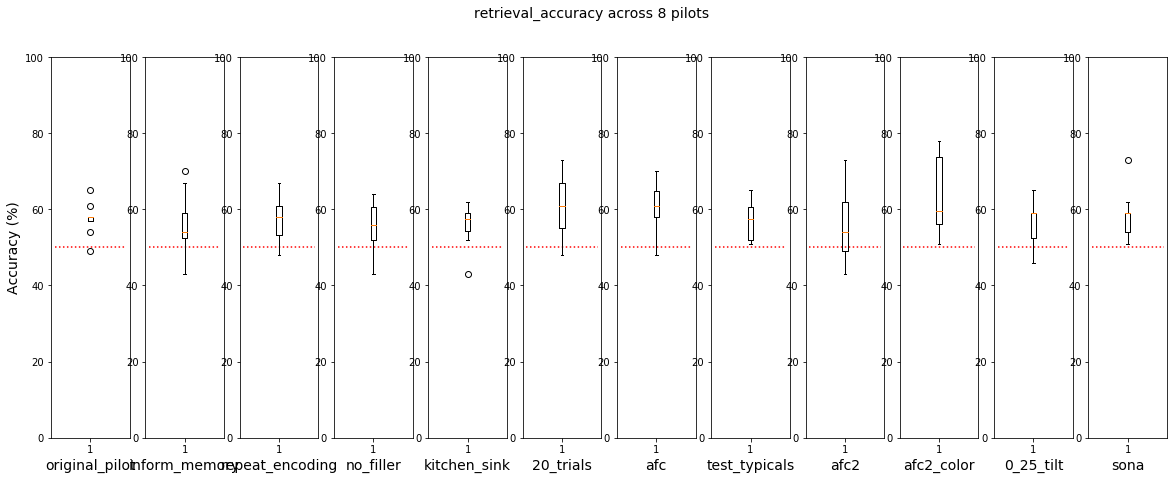

In [27]:
# plot 
lims = (0,100)
fs = 14
show = ['retrieval_accuracy']

for i in show:
    
    fig, axs = plt.subplots(1, len(df), figsize=(20,7))
    fig.suptitle(i + ' across 8 pilots', fontsize=fs)
    axs[0].set_ylabel('Accuracy (%)', fontsize=fs)
    
    for j in range(len(axs)):
        axs[j].plot([0, 2],[50, 50], color='red', linestyle=':')
        axs[j].boxplot(df_sum[j][i])
        axs[j].set_xlabel(key[j], fontsize = fs)
        axs[j].set_ylim(lims)
    
    plt.show()

## Next: summarize each pilot

### 1. Original_pilot
In this pilot (n=10), we used a 40-trial encoding task (20 of each race black/white), a 1-min filler, and a 72-trial sequential slider retrieval task (32 new, 40 old; half of the old faces were tilted by 50˚, creating 10 old trials in each analytical bucket of race x tilt condition). 

Summary of performance across 3 tasks:

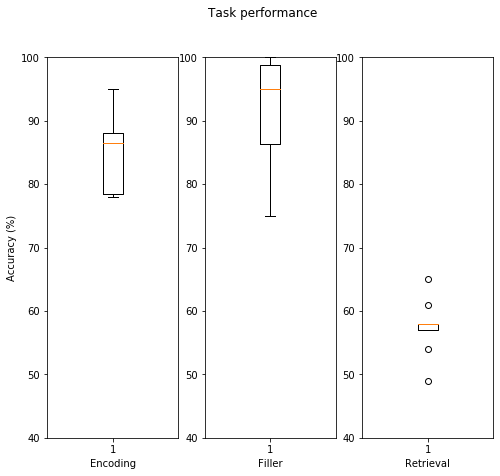

In [30]:
summary_plot(df_sum[0])

In [31]:
stats = get_stats(df[0])

can use 'stats' above for encoding_plot(stats), encoding_filler_plot(stats), encoding_retrieval_plot(stats), encoding_rt_delta_plot(stats), encoding_acc_delta_plot(stats), retrieval_black_white_plot(stats) 

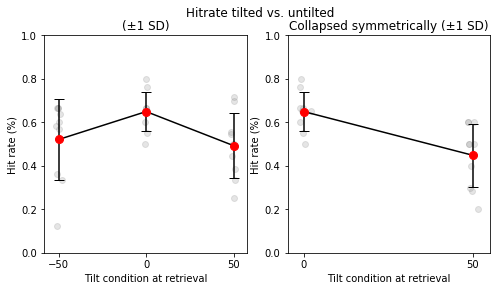

In [32]:
hit_tilt_plot(stats)

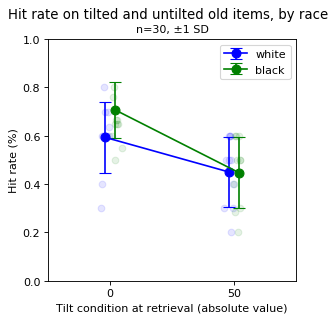

In [33]:
hit_tilt_race_plot(stats)

### 2. Inform_memory
N=10. 40-trial encoding, 72-trial retrieval. But here, subjects were informed from the start that they would later be tested on their memory for faces in part 1, so they should do their best to remember them.

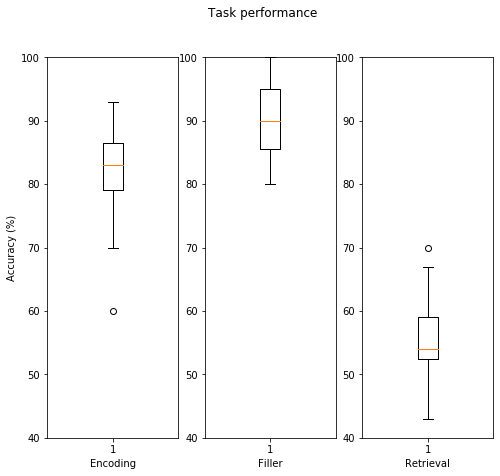

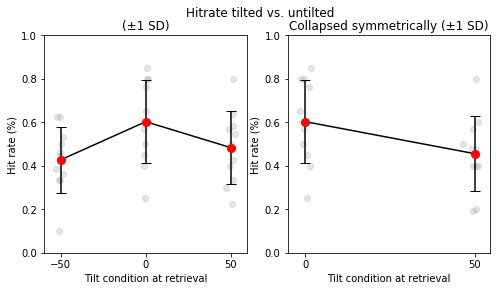

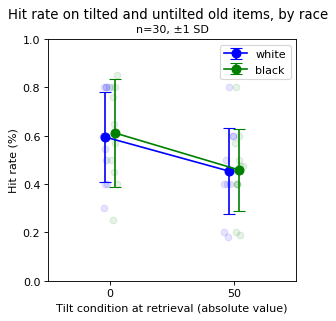

In [34]:
summary_plot(df_sum[1])
stats = get_stats(df[1])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 3. Repeat encoding
N=10. 40-trial encoding *repeated twice* for 80 total trials, 72-trial retrieval.

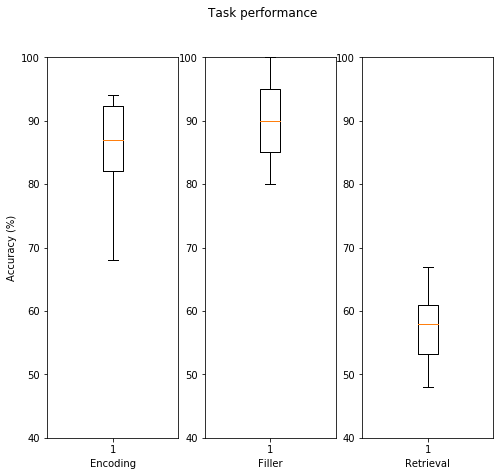

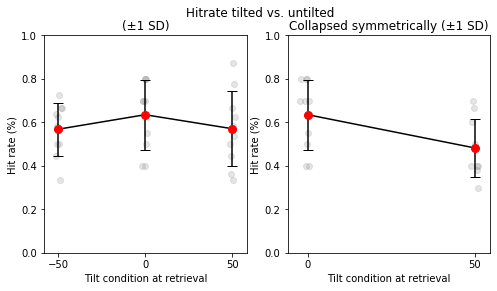

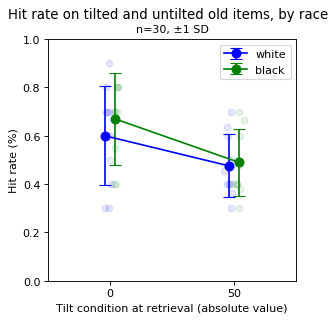

In [35]:
summary_plot(df_sum[2])
stats = get_stats(df[2])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 4. No filler
N=10. 40-trial encoding, 72-trial retrieval, but now NO FILLER TASK in between.

/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


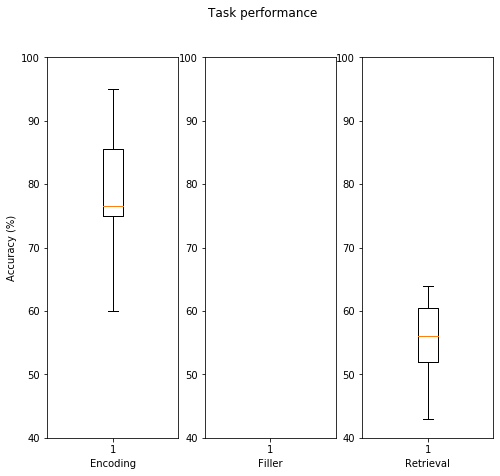

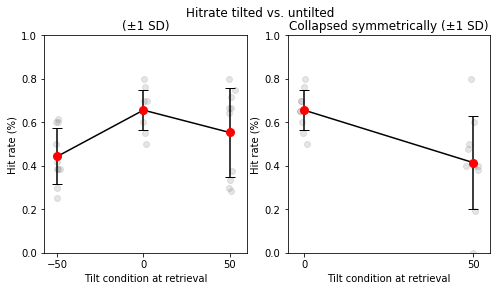

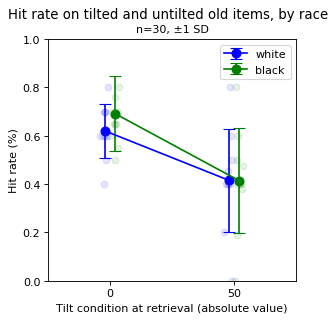

In [36]:
summary_plot(df_sum[3])
stats = get_stats(df[3])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 5. Kitchen sink
N=10. 40-trial encoding *repeated twice* for 80 total trials, *no filler task*, 72-trial retrieval, *and* subjects were informed that there would be a memory test.

/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/Applications/anaconda3/envs/memory_bias/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


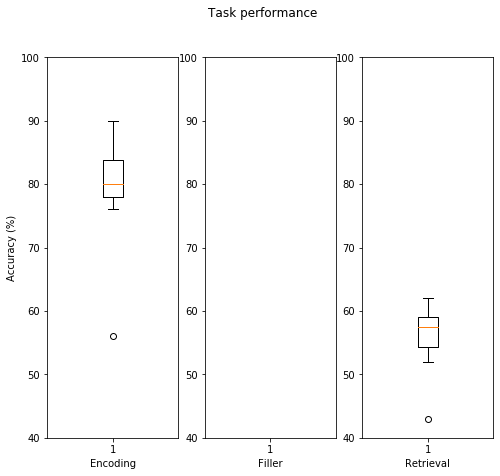

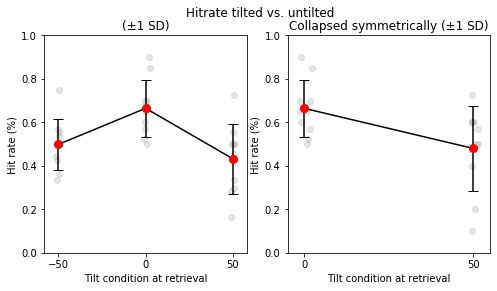

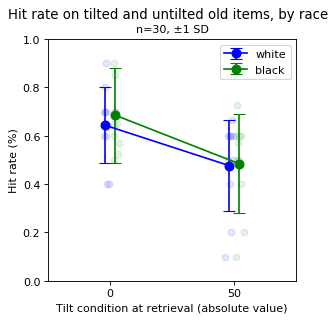

In [37]:
summary_plot(df_sum[4])
stats = get_stats(df[4])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 6. 20_trials
N=8. 20-trial encoding (half length), 1-min filler task, 36-trial retrieval.

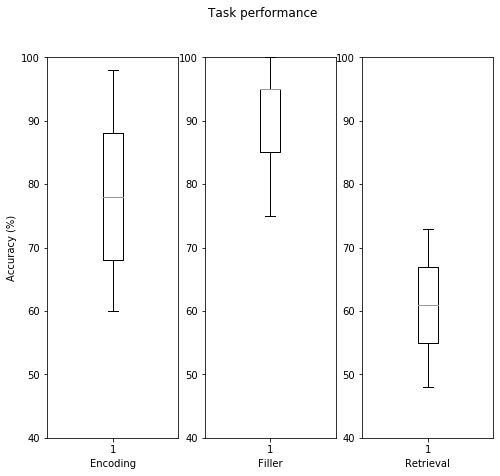

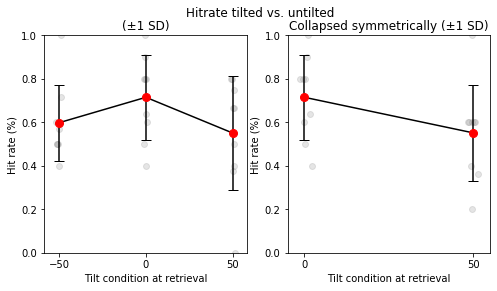

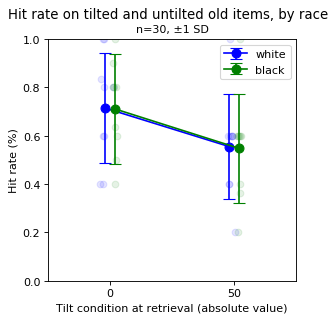

In [38]:
summary_plot(df_sum[5])
stats = get_stats(df[5])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 7. afc
N=8. 36-trial encoding (face # limitations), 1-min filler task, 36-trial retrieval in 2-AFC format with just arrow button presses.

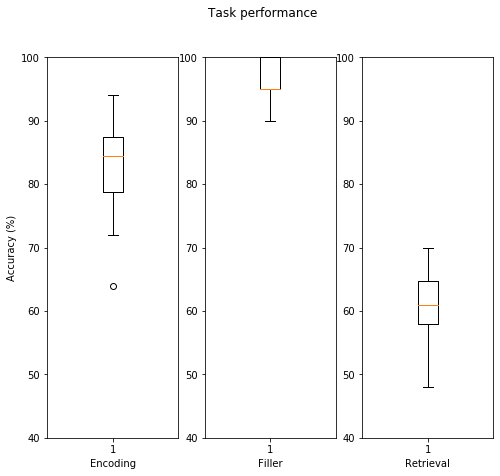

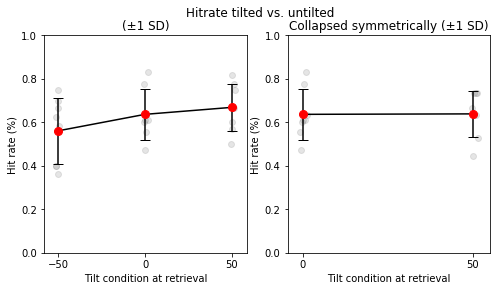

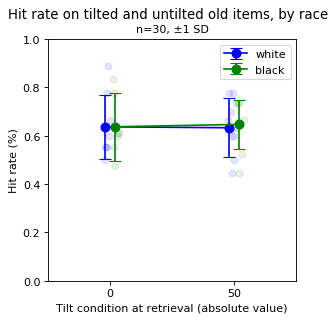

In [39]:
summary_plot(df_sum[6])
stats = get_stats(df[6])
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 8. test_typicals
N=8. 40-trial encoding, 1-min filler task, 72-trial sequential retrieval but tested on typicals, not oddities at retrieval (tilted = a viewpoint that doesn't match either viewpoint shown at encoding).

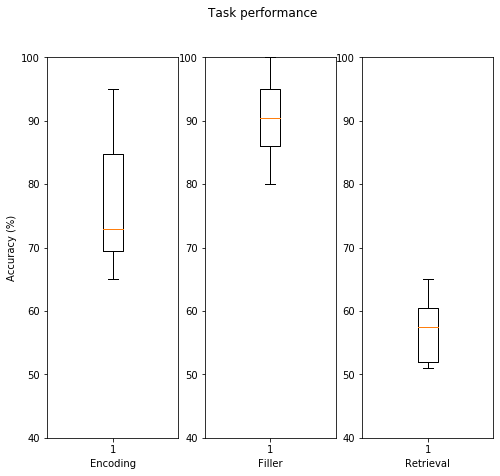

ZeroDivisionError: division by zero

In [40]:
summary_plot(df_sum[7])
stats = get_stats(df[7]) # this doesn't work because 'tilted' is not calculated properly above, 
                        #'tilt_change' and 'tilt_difference' are 2-item arrays. Fix later or never.
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 9. afc2
N=8. 40-trial encoding, 1-min filler task, 40-trial 2-AFC retrieval task. But this time, 1) the AFC used a slider, and 2) each old face was paired with an 'other-race' new face, rather than same race (as before).

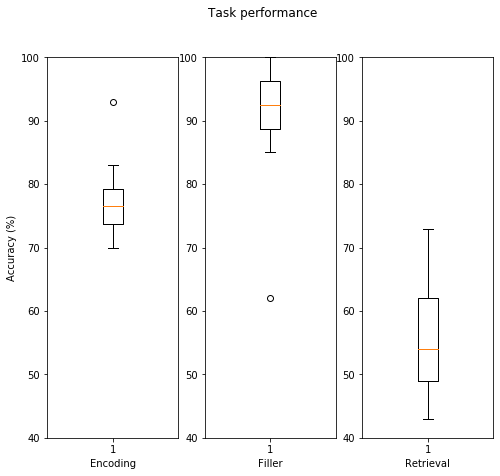

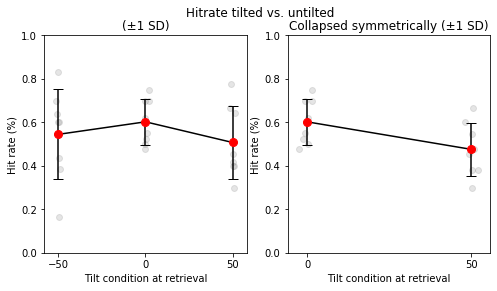

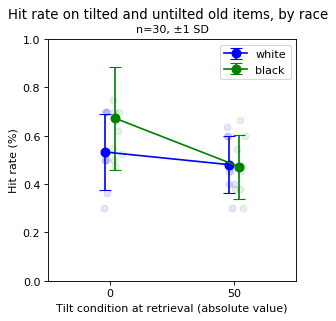

In [41]:
summary_plot(df_sum[8])
stats = get_stats(df[8]) # this doesn't work because 'tilted' is not calculated properly above, 
                        #'tilt_change' and 'tilt_difference' are 2-item arrays. Fix later or never.
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)

### 10. afc2_color
N=8. Same as (9) but used colorized stimuli.

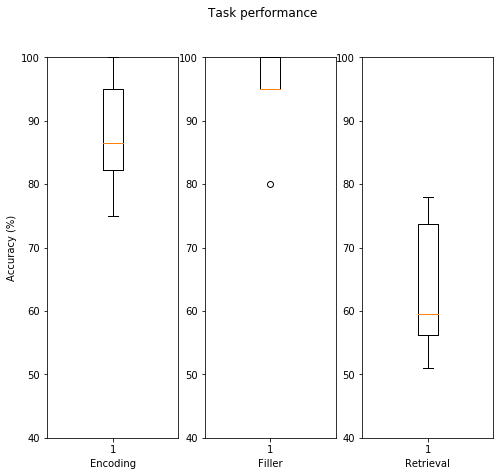

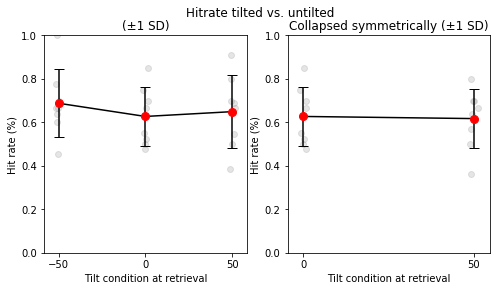

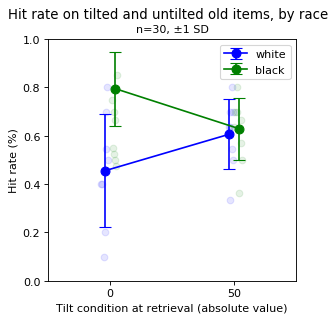

In [42]:
summary_plot(df_sum[9])
stats = get_stats(df[9]) # this doesn't work because 'tilted' is not calculated properly above, 
                        #'tilt_change' and 'tilt_difference' are 2-item arrays. Fix later or never.
hit_tilt_plot(stats)
hit_tilt_race_plot(stats)